<a href="https://colab.research.google.com/github/asetya/BigData/blob/master/sparkMlibReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PERSIAPAN**

Diadaptasi dari : 
https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

Tujuan dari contoh ini adalah untuk prediksi apakah client akan  subscribe (Yes/No) untuk program deposito


1. Install Java open Jdk 

In [1]:
# Install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

2. Download spark 


In [2]:
# Install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

3. Unzip spark

In [4]:
# Unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

4. Setting Java Home dan Spark Home

In [5]:
# Set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

6. Install findspark 

In [6]:
# Install findspark using pip
!pip install -q findspark

7. Inisialisasi Spark

In [7]:
import findspark
findspark.init() 

8. Download data bank.csv dari https://www.kaggle.com/rouseguy/bankbalanced/data

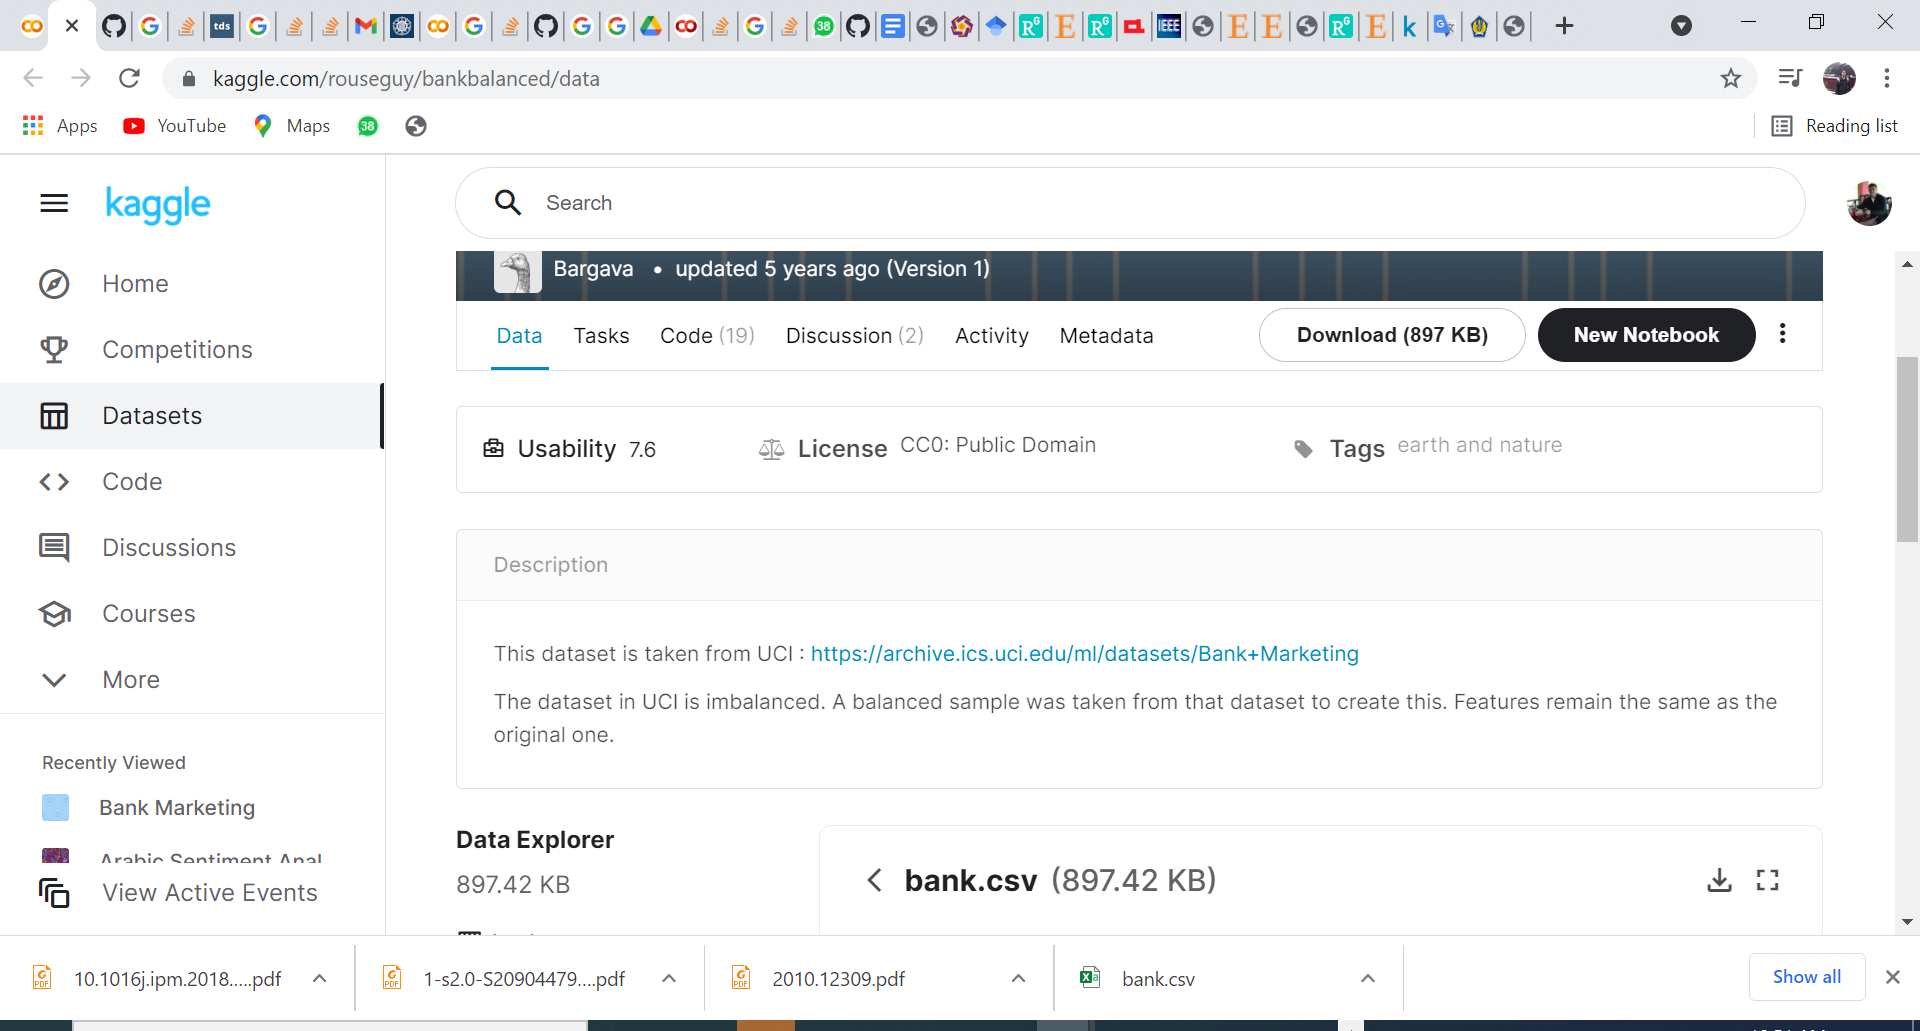




Simpan Di folder LOkal anda

Lanjutkan dengan mengupload ke folder Content di Google Colab Anda dengan cara : 

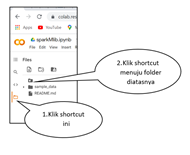

Lalu Klik tanda titik 3 di sebelah kanan folder Content

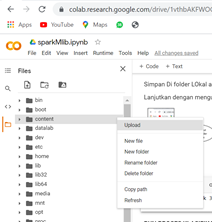

Pilih File Bank.csv yang sudah anda download di komputer lokal anda 

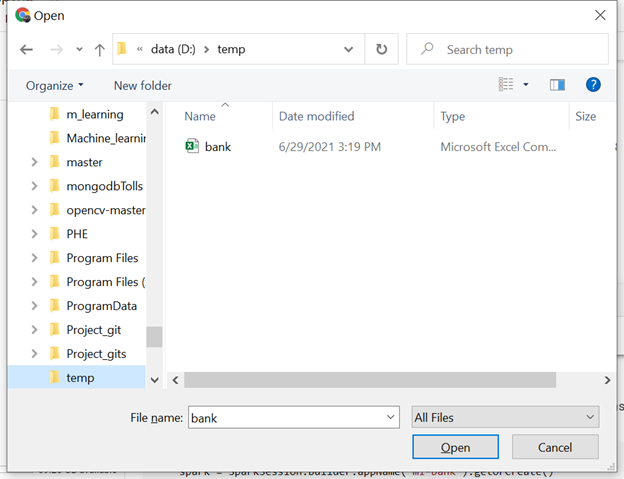


**RUN PROSES REGRESI**

1. Import and create streaming context. Next, we will import and create a new instance of Spark's StreamingContext:

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('mlcovid').getOrCreate()
df = spark.read.csv('covid.csv', header = True, inferSchema = True)
df.printSchema()



root
 |-- Country/Region: string (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Recovered: integer (nullable = true)
 |-- Active: integer (nullable = true)
 |-- New cases: integer (nullable = true)
 |-- New deaths: integer (nullable = true)
 |-- New recovered: integer (nullable = true)
 |-- Deaths / 100 Cases: double (nullable = true)
 |-- Recovered / 100 Cases: double (nullable = true)
 |-- Deaths / 100 Recovered: string (nullable = true)
 |-- Confirmed last week: integer (nullable = true)
 |-- 1 week change: integer (nullable = true)
 |-- 1 week % increase: double (nullable = true)
 |-- WHO Region: string (nullable = true)



2. Menggunakan pandas untuk mengelola data yang sudah dibaca

In [9]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola
Confirmed,36263,4880,27973,907,950
Deaths,1269,144,1163,52,41
Recovered,25198,2745,18837,803,242
Active,9796,1991,7973,52,667
New cases,106,117,616,10,18
New deaths,10,6,8,0,1
New recovered,18,63,749,0,0
Deaths / 100 Cases,3.5,2.95,4.16,5.73,4.32
Recovered / 100 Cases,69.49,56.25,67.34,88.53,25.47


3. tampilkan summary statistic 

In [11]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Confirmed,187,88130.935828877,383318.6638306154,10,4290259
Deaths,187,3497.51871657754,14100.00248201848,0,148011
Recovered,187,50631.48128342246,190188.18964313966,0,1846641
Active,187,34001.935828877,213326.17337142891,0,2816444
New cases,187,1222.957219251337,5710.374790280563,0,56336
New deaths,187,28.9572192513369,120.03717295550823,0,1076
New recovered,187,933.812834224599,4197.719634688254,0,33728
Confirmed last week,187,78682.47593582887,338273.67656653706,10,3834677
1 week change,187,9448.459893048128,47491.12768403526,-47,455582


4. tampilkan korelasi antar kolom 

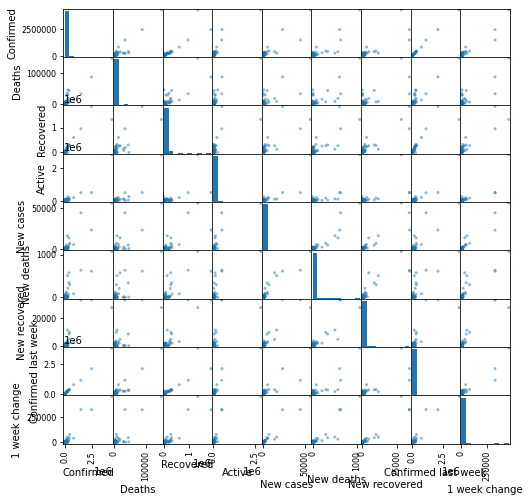

In [12]:
from pandas.plotting import scatter_matrix
numeric_data = df.select(numeric_features).toPandas()
scatter_matrix(numeric_data, figsize=(8, 8));


Tidak terdeteksi korelasi antar variabel numerik sehingga atribut nbumerik bisa tetap dipertahankan, sedangkan atribut day month akan dibuanmg karena tidak relalu bermanfaat
5. pilih fitur (variabel/kolom) 

In [13]:
df = df.select('Confirmed', 'Deaths', 'Recovered')
cols = df.columns
df.printSchema()

root
 |-- Confirmed: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Recovered: integer (nullable = true)



**MESIN LEARNING**

1. PERSIAPAN 

catatan jika anda menggunakan pysaprk dibawah 2.4 gunakan 'OneHotEncoderEstimator' Jika anda menggunakan versi 2.4 ke atas gunakan 'OneHotEncoder'

In [14]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['Country/Region', 'WHO Region']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Kode diatas diambil dari  databricks’ official site (https://docs.databricks.com/applications/machine-learning/train-model/mllib/index.html#binary-classification-example) dicopy dari sumber diatas. Bermaksud mengindeks kolom kategorikal menggunakan StringIndexer, lalu mengkonversinya menggunakan  one-hot encoder. 

The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

2. PIPELINE 
Kita akan menggunakan beberapa transformer dan estimator bersamaan untuk pipeline mesin learning kita. Pipelinenya diurutkan seperti dibawah ini 



In [15]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

Py4JJavaError: ignored

tampilkan dataset setelah transformasi - 5 bari saja

In [16]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
Confirmed,36263,4880,27973,907,950
Deaths,1269,144,1163,52,41
Recovered,25198,2745,18837,803,242


3. MEMBAGI DATASET MENJADI TRAINING DAN TESTING 

komposisi 70% dan 30% untuk training dan testing 

In [17]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print(" Data Latih( Training): " + str(train.count()))
print("Data Test: " + str(test.count()))

 Data Latih( Training): 126
Data Test: 61


4. MEMBANGUN MODEL REGRESI 

In [19]:
#from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
#lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8,featuresCol ='Deaths',labelCol = 'Confirmed' )
lrModel = lr.fit(train)

IllegalArgumentException: ignored

We can obtain the coefficients by using LogisticRegressionModel’s attributes.

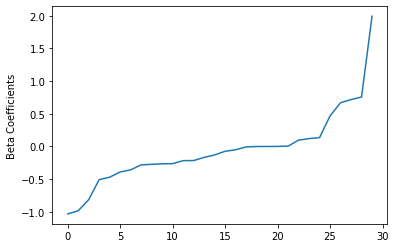

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

Summarize the model over the training set, we can also obtain the receiver-operating characteristic and areaUnderROC.

In [ ]:
trainingSummary = lrModel.summary
print ("hasil training : ")
print ("akurasi : ",trainingSummary.accuracy)
print ("presisi rata rata :", trainingSummary.weightedPrecision)
print ("recall rata rata :", trainingSummary.weightedRecall)
print ("Area under ROC:", trainingSummary.areaUnderROC)


hasil training : 
akurasi :  0.8056015276893699
presisi rata rata : 0.806011934581965
recall rata rata : 0.8056015276893698
Area under ROC: 0.8865478305561797


4. MENERAPKAN MODEL REGRESI PADA DATA TEST

In [ ]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(20)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93500470498078...|       0.0|[0.87380233100701...|
| 49|management|  0.0|[2.04809361205494...|       0.0|[0.88575484704982...|
| 52|management|  0.0|[-0.7002122133357...|       1.0|[0.33176517908283...|
| 53|management|  0.0|[1.03431610227355...|       0.0|[0.73775180622517...|
| 58|management|  0.0|[2.74273671692568...|       0.0|[0.93950183380104...|
| 32|management|  0.0|[1.25033004378243...|       0.0|[0.77735698810450...|
| 57|management|  0.0|[1.19540519867322...|       0.0|[0.76770638557283...|
| 52|management|  0.0|[3.26456982709638...|       0.0|[0.96319314409492...|
| 46|management|  0.0|[2.15036209979034...|       0.0|[0.89570260888977...|
| 31|management|  0.0|[1.47751802200863...|       0.0|[0.81419739986183...|
| 50|managem

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))


Test Area Under ROC 0.8837112925002687


5 MENERAPKAN MODELLING DAN EVALUASI MENGGGUNAKAN DECISSION TREE 

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

Evaluasi testing dengan decission Tree 

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7808118726917547


6. Gradient-Boosted Tree Classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[0.94992370947246...|       0.0|[0.86987425549896...|
| 49|management|  0.0|[1.28281748604659...|       0.0|[0.92861688965145...|
| 52|management|  0.0|[-0.5021429054421...|       1.0|[0.26809961471379...|
| 53|management|  0.0|[0.09646513340517...|       0.0|[0.54808351175538...|
| 58|management|  0.0|[1.05831377292163...|       0.0|[0.89250881497055...|
| 32|management|  0.0|[0.57268875896254...|       0.0|[0.75866558918304...|
| 57|management|  0.0|[0.34932946844840...|       0.0|[0.66789037418062...|
| 52|management|  0.0|[1.33264456943866...|       0.0|[0.93494709840561...|
| 46|management|  0.0|[1.28262818068783...|       0.0|[0.92859178839697...|
| 31|management|  0.0|[1.16094954405484...|       0.0|[0.91067454521219...|
+---+-------

Evaluasi dengan GBT 

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8935091626908479


MENAMPILKAN PARAMETER YANG DIPAKAI GBT DENGAN PERFORMA TERBAIK DIANTARA YANG LAIN 

In [ ]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

Gradient-Boosted Tree mencapai hasil terbaik, kami akan mencoba menyetel model ini dengan ParamGridBuilder dan CrossValidator. Sebelum itu kita dapat menggunakan explainParams() untuk mencetak daftar semua param dan definisinya untuk memahami param apa yang tersedia untuk penyetelan.

7. MENCOBA MENGGUNAKAN GRIN UNTUK MEMILIH PARAMETER TERBAIK DAN MENGUJI MENGGUNAKAN KROS VALIDASI DENGAN 5 FOLD 

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8954659543871663

**TUGAS**

1. coba dijajagi menggunakan alhgoritma klasifikasi yang lain 
2. coba dijajagi menggunakan dataset yang lebih kompleks misal menggunakan 3 4  atau lebih kelas 

